# CNN-Based Stock Price Prediction

In this notebook, we develop a 1D Convolutional Neural Network (CNN) to forecast the next-day closing price of a stock using historical time series data. CNNs are capable of capturing local temporal patterns and are computationally efficient compared to RNNs.


Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout, MaxPooling1D

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from financial_metrics import FinancialMetrics

# Plot style
sns.set(style="whitegrid")

Load and Inspect Data

In [2]:
# Load processed data
df = pd.read_csv("processed_stock_data.csv", parse_dates=["Date"])
df.set_index("Date", inplace=True)
df = df[["Close/Last"]]  # Using only close prices for CNN input

df.tail()

,Close/Last
Date,
2024-08-29,206.28
2024-08-30,214.11
2024-09-03,210.60
2024-09-04,219.41
2024-09-05,230.17


Data Normalization and Sequence Preparation

To prepare Time Series Data for CNN, we use a sliding window approach with window_size = 10 (10 past days → 1 next-day prediction).

In [3]:
# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Sliding window
def create_sequences(data, window):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i + window])
        y.append(data[i + window])
    return np.array(X), np.array(y)

window_size = 10
X, y = create_sequences(scaled_data, window_size)

# Reshape for Conv1D: (samples, timesteps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

X_train shape: (168, 10, 1), y_train shape: (168, 1)


Build the CNN Model

In [4]:
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(window_size, 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)  # Output: next day's normalized close price
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 8, 64)          │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │        12,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,157 (51.39 KB)

 Trainable params: 13,157 (51.39 KB)

 Non-trainable params: 0 (0.00 B)

Train the CNN Model

In [5]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_split=0.1,
    verbose=1
)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 259ms/step - loss: 0.1716 - mae: 0.3335 - val_loss: 0.0178 - val_mae: 0.1044
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0336 - mae: 0.1513 - val_loss: 0.0308 - val_mae: 0.1119
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0116 - mae: 0.0879 - val_loss: 0.0471 - val_mae: 0.1611
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0153 - mae: 0.0985 - val_loss: 0.0275 - val_mae: 0.1044
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0121 - mae: 0.0885 - val_loss: 0.0299 - val_mae: 0.1135
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0083 - mae: 0.0675 - val_loss: 0.0324 - val_mae: 0.1243
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0077 - mae: 0.0693 - val_loss: 0.0308 - val_mae: 0.1221
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0078 - mae: 0.0706 - val_loss: 0.0298 - val_mae: 0.1215
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0088 - ma

Plot Training Loss History

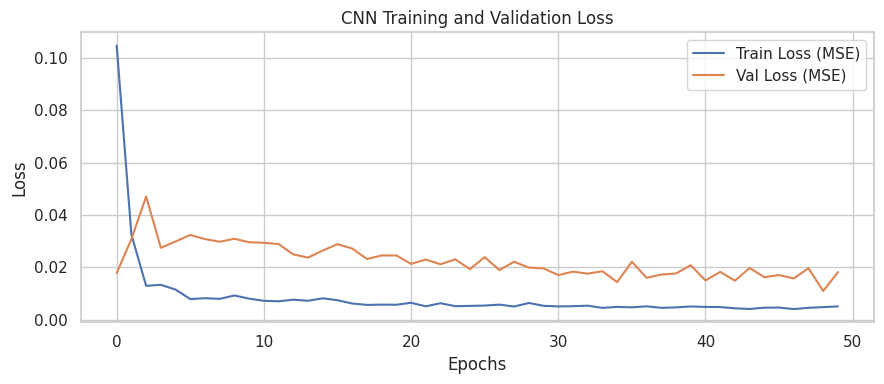

In [6]:
plt.figure(figsize=(9, 4))
plt.plot(history.history["loss"], label="Train Loss (MSE)")
plt.plot(history.history["val_loss"], label="Val Loss (MSE)")
plt.title("CNN Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

Evaluate on Test Set

In [7]:
y_pred = model.predict(X_test)

# Inverse scale predictions and targets
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluation Metrics
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"Test MAE: {mae:.2f}")
print(f"Test RMSE: {rmse:.2f}")
print(f"Test R^2: {r2:.2f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step
Test MAE: 9.14
Test RMSE: 11.24
Test R^2: 0.67


In [9]:
y_test_series = pd.Series(y_test_inv.ravel())
y_pred_series = pd.Series(y_pred_inv.ravel())

# Financial metrics
returns = y_pred_series.pct_change().dropna()
fm = FinancialMetrics(risk_free_rate=0.01)
results = fm.evaluate_all(y_test_series, y_pred_series, returns)
display(pd.json_normalize(results))

,Directional Accuracy (%),Cumulative Return (%),Sharpe Ratio,Max Drawdown (%)
0,45.24,-10.4,-2.29,-23.28


Plot Predictions vs Actuals

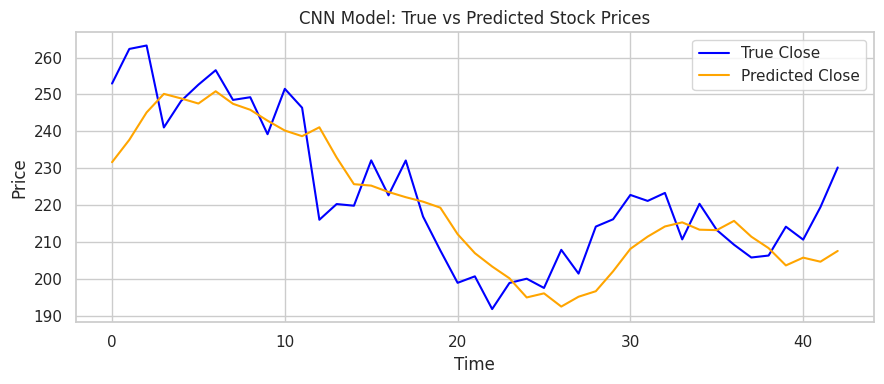

In [10]:
plt.figure(figsize=(9, 4))
plt.plot(y_test_inv, label="True Close", color="blue")
plt.plot(y_pred_inv, label="Predicted Close", color="orange")
plt.title("CNN Model: True vs Predicted Stock Prices")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()